In [1]:
%pylab nbagg
from tvb.simulator.lab import *
import numpy

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


c:\users\gabriel.florea\desktop\mywork\tvb_2\tvb-library\tvb\datatypes\surfaces.py:66: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wilson_cowan.WilsonCowan.state_variable_range = Final(field_type=<class 'dict'>, default={'E': array([0., 1.]), 'I': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.st

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wong_wang_exc_io_inh_i.ReducedWongWangExcIOInhI.state_variable_range = Final(field_type=<class 'dict'>, default={'S_e': array([0., 1.]), 'S_i': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.linear.Linear.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-1,  1])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.hopfield.Hopfield.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-1.,  2.]), 'theta': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_var

# Tutorial: Modeling The Impact of Structural Lesions -- Part II: The Brain Network Model

In this tutorial we will show the steps required to build the network model used in [1]. First, the dynamics of the uncoupled network will be explored (ie, single node dynamics). Second, you can either run the script 'region_deterministic_modeling_structural_lesions.py' or execute the code cell to obtain some sample time-series. Running time for a complete 10 minutes long simulation using the 998 ROIs Hagmann connectome takes about 5 days, for an integration time step size of 0.2 ms. Even though empirical BOLD data length is in the order of ten of minutes, for the purposes of understanding the stages of this modeling pipeline we suggest to execute short simulations. 

In [2]:
lb = models.LarterBreakspear(QV_max=numpy.array([1.0]), QZ_max=numpy.array([1.0]), 
                             d_V=numpy.array([0.65]), d_Z=numpy.array([0.65]), 
                             aee=numpy.array([0.36]), ani=numpy.array([0.4]), ane=numpy.array([1.0]))

lb.variables_of_interest = ["V", "W", "Z"]


white_matter = connectivity.Connectivity.from_file("connectivity_66.zip")
white_matter.speed = numpy.array([7.0])

white_matter_coupling = coupling.HyperbolicTangent(a=numpy.array([0.5*lb.QV_max]), 
                                                   midpoint=lb.VT, 
                                                   sigma=lb.d_V,)

#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=0.2)

#Initialise some Monitors with period in physical time
mon_tavg =  monitors.TemporalAverage(period=2.)
mon_bold  = monitors.Bold(period=2000.)

#Bundle them
what_to_watch = (mon_bold, mon_tavg)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = lb, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, 
                          monitors = what_to_watch)

sim.configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity
coupling,HyperbolicTangent
initial_conditions,None
integrator,HeunDeterministic
model,LarterBreakspear
monitors,"(, )"
simulation_length,1000.0
stimulus,None


In [3]:
#Perform the simulation
bold_data, bold_time = [], []
tavg_data, tavg_time = [], []

for raw, tavg in sim(simulation_length=2000):
    if not raw is None:
        bold_time.append(raw[0])
        bold_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

In [4]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


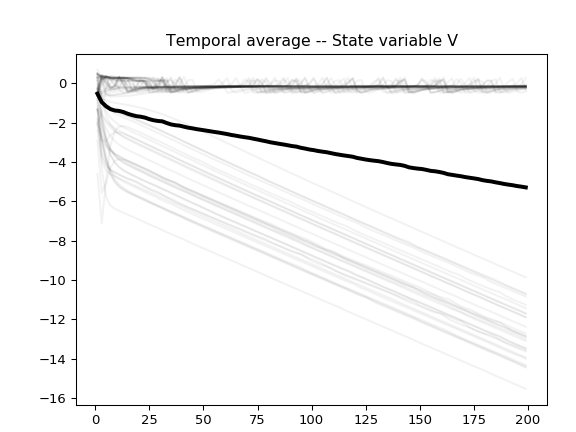

<IPython.core.display.Javascript object>


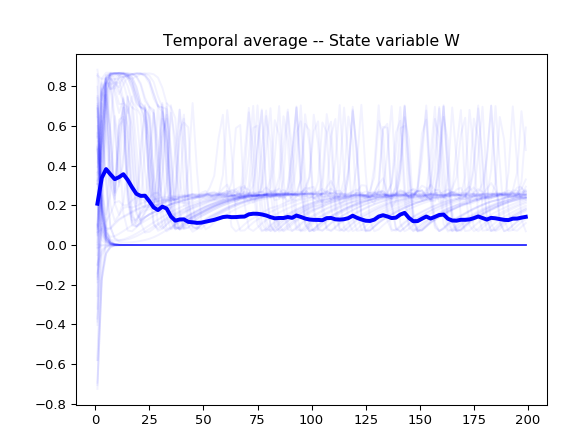

<IPython.core.display.Javascript object>


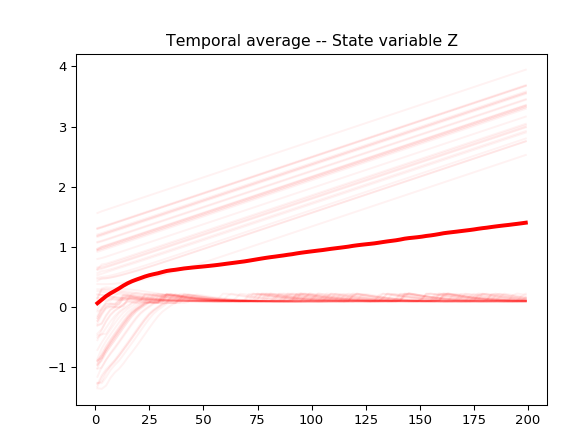

Text(0.5, 0, 'time [ms]')

In [5]:
#Make the lists numpy.arrays for easier use.
BOLD = numpy.array(bold_data)
TAVG = numpy.array(tavg_data)
tavg_time = numpy.array(tavg_time)
t_interval=numpy.arange(100)

#Plot raw time series
figure(1)
plot(tavg_time[t_interval], TAVG[t_interval, 0, :, 0], 'k', alpha=0.05)
plot(tavg_time[t_interval], TAVG[t_interval, 0, :, 0].mean(axis=1), 'k',  linewidth=3)
title("Temporal average -- State variable V")

figure(2)
plot(tavg_time[t_interval], TAVG[t_interval, 1, :, 0], 'b', alpha=0.05)
plot(tavg_time[t_interval], TAVG[t_interval, 1, :, 0].mean(axis=1), 'b', linewidth=3)
title("Temporal average -- State variable W")

figure(3)
plot(tavg_time[t_interval], TAVG[t_interval, 2, :, 0], 'r', alpha=0.05)
plot(tavg_time[t_interval], TAVG[t_interval, 2, :, 0].mean(axis=1), 'r', linewidth=3)
title("Temporal average -- State variable Z")
xlabel('time [ms]', fontsize=24)


<IPython.core.display.Javascript object>


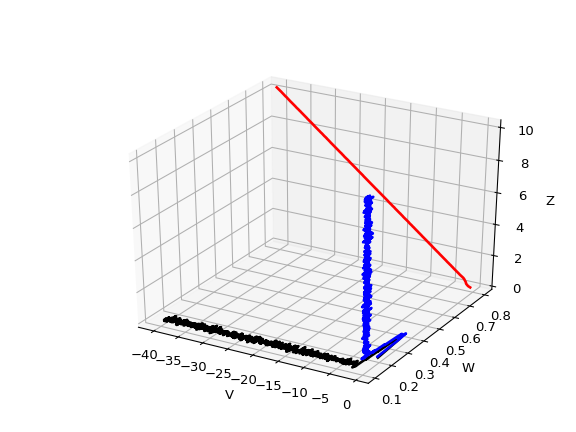

In [6]:
#Plot 3D trajectories
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(4)
ax = fig.gca(projection='3d')


ax.plot(TAVG[:, 0, :, 0].mean(axis=1),  TAVG[:, 1, :, 0].mean(axis=1), 'k', zs=0.0, zdir='z', linewidth=2)
ax.plot(TAVG[:, 1, :, 0].mean(axis=1),  TAVG[:, 2, :, 0].mean(axis=1), 'b', zdir='x', zs=-0.6,linewidth=2)
ax.plot(TAVG[:, 0, :, 0].mean(axis=1),  TAVG[:, 2, :, 0].mean(axis=1), 'r', zdir='y', zs=0.8,linewidth=2)
ax.set_xlabel('V')
ax.set_ylabel('W')
ax.set_zlabel('Z')
plt.show()


<IPython.core.display.Javascript object>


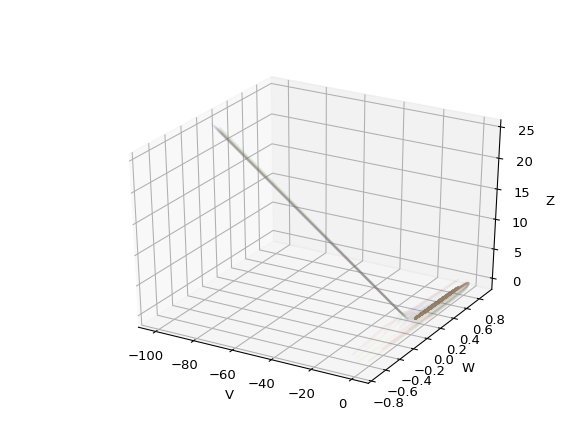

Text(0.5, 0, 'Z')

In [7]:
fig = plt.figure(6)
ax = fig.gca(projection='3d')


for node in range(white_matter.number_of_regions):
    ax.plot(TAVG[:, 0, node, 0], TAVG[:, 1, node, 0], TAVG[:, 2, node, 0], alpha=0.05)


ax.set_xlabel('V')
ax.set_ylabel('W')
ax.set_zlabel('Z')


[1] Alstott et al. (2009) Modeling the impact of lesions in the human brain. Plos Comp Bio.
